# ePSproc - basic plotting development
28/06/20

Aims

- Improve/automate basic plotting routines ([currently using Xarray.plot.line() for the most part](https://epsproc.readthedocs.io/en/latest/ePSproc_demo_Aug2019/ePSproc_demo_Aug2019.html)).
  - Plot format & styling (use Seaborn?)
- Test & implement plotting over multiple Xarrays for data comparisons. (E.g. [XeF2 plotting, updates to follow when AntonJr is back up](https://phockett.github.io/ePSdata/XeF2-preliminary/XeF2_multi-orb_comparisons_270320-dist.html#Plot-ePS-GetCro-results---X-sections-and-Betas---photon-energy).)
  - Conversion to Xarray datasets?
  - Use Holoviews?
- Improve export formats
  - HV + Bokeh for interactive HTML outputs (e.g. [benchmarks graphs via xyzpy](https://epsproc.readthedocs.io/en/dev/tests/Low_level_bench_tests_Wigner3j_Feb2020.html#Benchmark-for-range-of-QN-arrays-with-xyzpy.benchmarker)).
  
03/07/20: some HV plotting seems to now be broken, likely due to version update. For simplified version - XC data only - see http://localhost:8888/notebooks/github/ePSproc/epsproc/tests/plottingDev/basicPlotting_dev_XC_030720.ipynb 

## Setup

In [1]:
# Standard libs
import sys
import os
from pathlib import Path
import numpy as np
import xarray as xr

from datetime import datetime as dt
timeString = dt.now()

In [2]:
# Installed package version
# import epsproc as ep  

# ePSproc test codebase (local)
if sys.platform == "win32":
    modPath = r'D:\code\github\ePSproc'  # Win test machine
else:
    modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
    
sys.path.append(modPath)
import epsproc as ep

* plotly not found, plotly plots not available. 
* pyevtk not found, VTK export not available. 


In [3]:
# Plotting libs
# Optional - set seaborn for plot styling
import seaborn as sns
sns.set_context("paper")  # "paper", "talk", "poster", sets relative scale of elements
                        # https://seaborn.pydata.org/tutorial/aesthetics.html
# sns.set(rc={'figure.figsize':(11.7,8.27)})  # Set figure size explicitly (inch)
                        # https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
                        # Wraps Matplotlib rcParams, https://matplotlib.org/tutorials/introductory/customizing.html
sns.set(rc={'figure.dpi':(120)})

from matplotlib import pyplot as plt  # For addtional plotting functionality
# import bokeh

import holoviews as hv
from holoviews import opts

## Load test data

In [4]:
# Load data from modPath\data
dataPath = os.path.join(modPath, 'data', 'photoionization')
dataFile = os.path.join(dataPath, 'n2_3sg_0.1-50.1eV_A2.inp.out')  # Set for sample N2 data for testing

# Scan data file
dataSet = ep.readMatEle(fileIn = dataFile)
dataXS = ep.readMatEle(fileIn = dataFile, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.

*** ePSproc readMatEle(): scanning files for DumpIdy segments.

*** Scanning file(s)
['/home/femtolab/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  /home/femtolab/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 102 DumpIdy segments.
Found 102 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 102 sets of DumpIdy file segments, (0 blank)
*** ePSproc readMatEle(): scanning files for CrossSection segments.

*** Scanning file(s)
['/home/femtolab/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  /home/femtolab/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 3 CrossSection segments.
Found 3 CrossSection segments (sets of results).
Process

## Xarray plotting

- Xarray [wraps Matplotlib functionality](http://xarray.pydata.org/en/stable/plotting.html). (And can be modified using Matplotlib calls, and will pick up Seaborn styling if set.)
- Easy to use, supports line and surface plots, with faceting. 
- Doesn't support high dimensionality directly, need to subselect and/or facet and then pass set of 1D or 2D values.
- Not interactive in Jupyter Notebook, or HTML, output.

/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


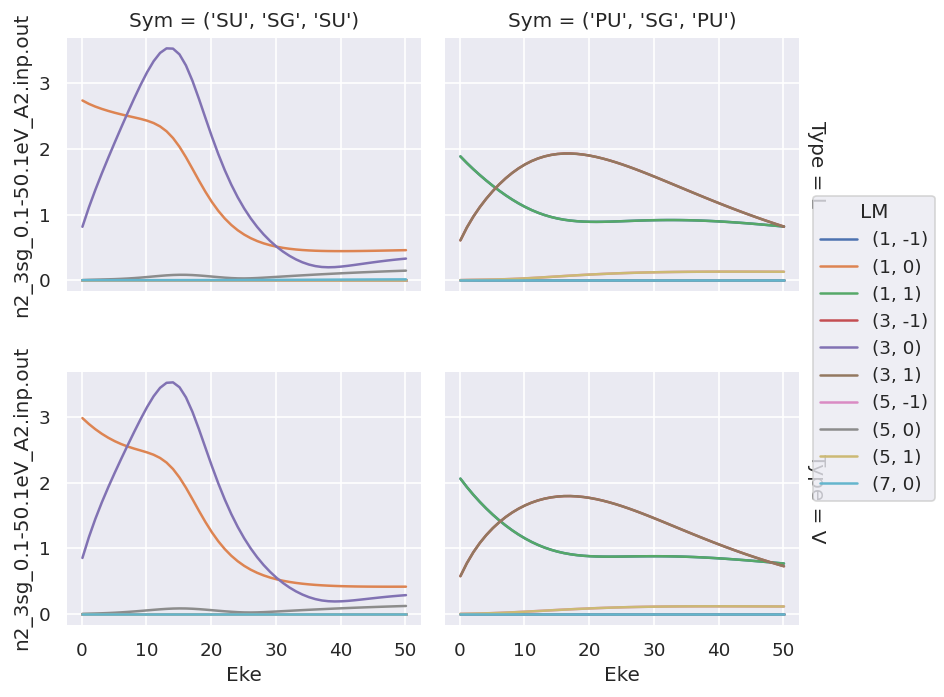

In [5]:
# Plot with faceting on symmetry
daPlot = ep.matEleSelector(dataSet[0], thres=1e-2, dims = 'Eke', sq = True).sum('mu').squeeze()
daPlot.pipe(np.abs).plot.line(x='Eke', col='Sym', row='Type');

/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


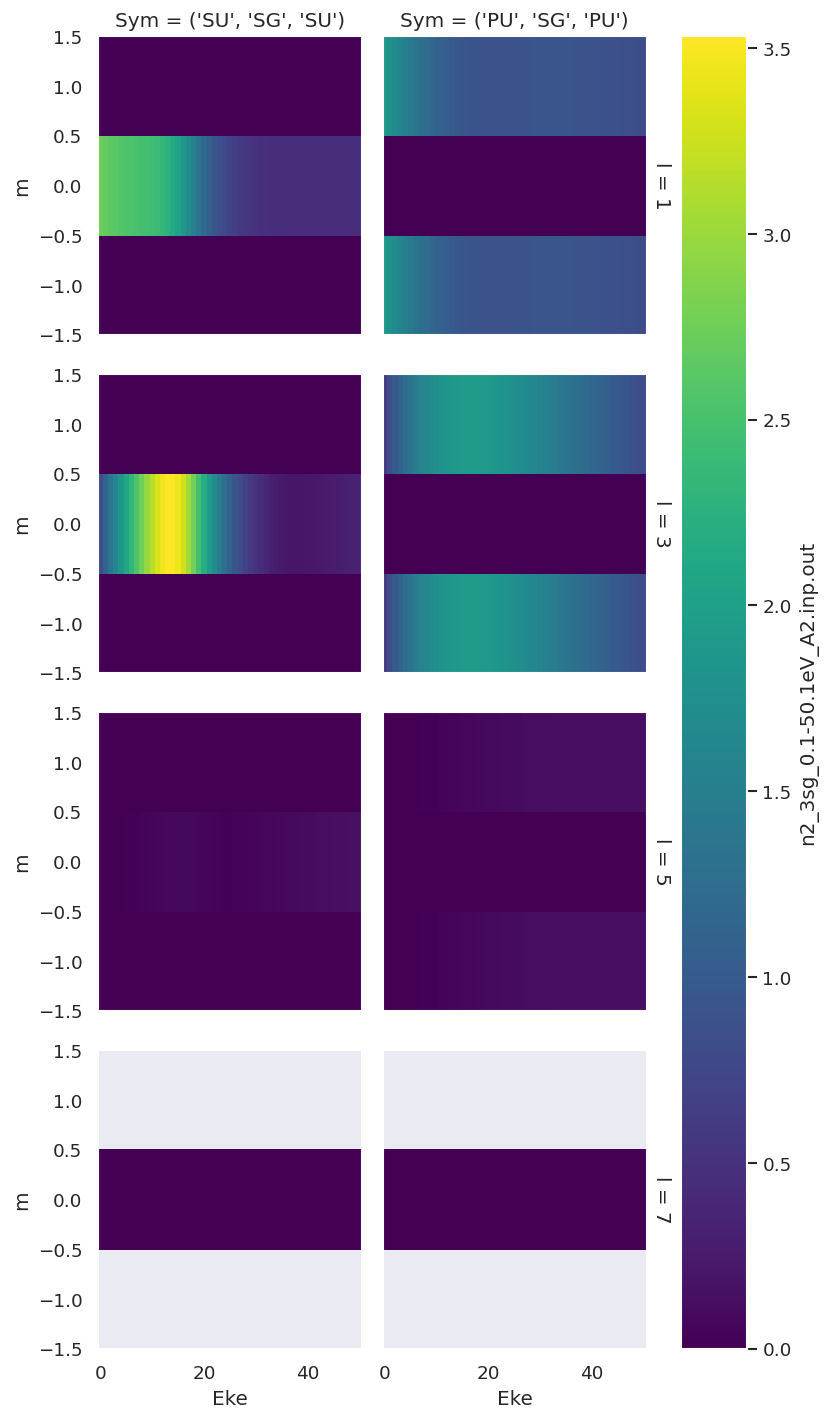

In [6]:
# Surface plots per (L,sym)
# Note that this requires 2D arrays per facet category pair.
# Multi-level dims are not supported.
daPlot = ep.matEleSelector(dataSet[0], thres=1e-2, dims = 'Eke', sq = True).sel({'Type':'L'}).sum('mu').squeeze()
daPlot.pipe(np.abs).unstack('LM').plot(x='Eke', y='m', col='Sym', row='l');

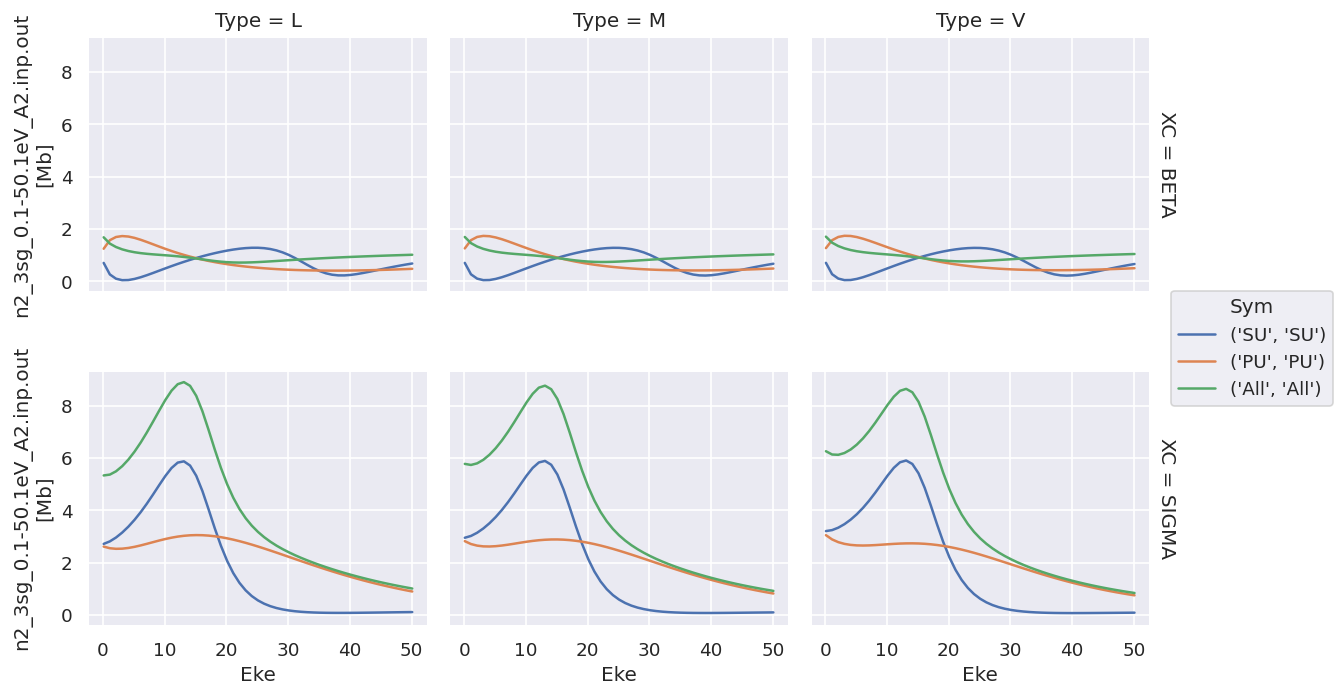

In [7]:
# For XS data - this works nicely, except (1) no control over ordering, (2) same y-axis for all data types.
# Plot with faceting
daPlot = ep.matEleSelector(dataXS[0], thres=1e-2, dims = 'Eke', sq = True).squeeze()
# daPlot.pipe(np.abs).plot.line(x='Eke', col='Type', row='XC');
daPlot.plot.line(x='Eke', col='Type', row='XC');

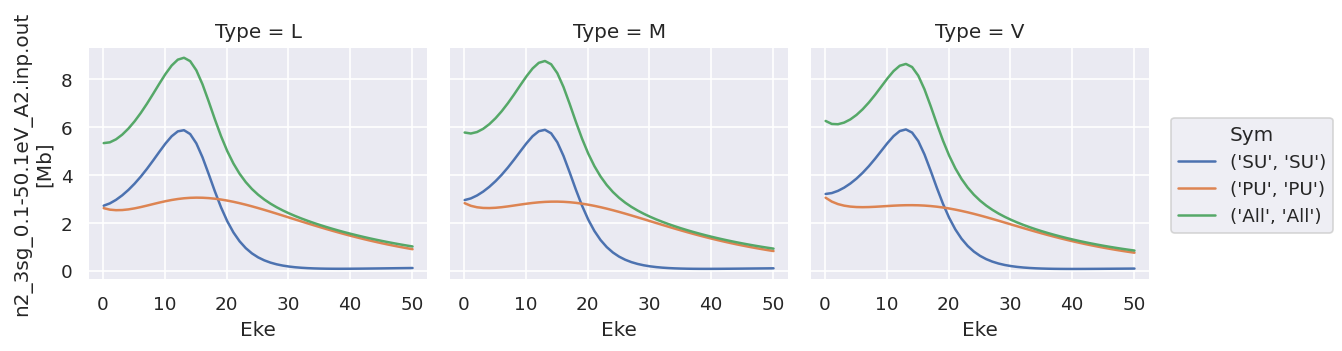

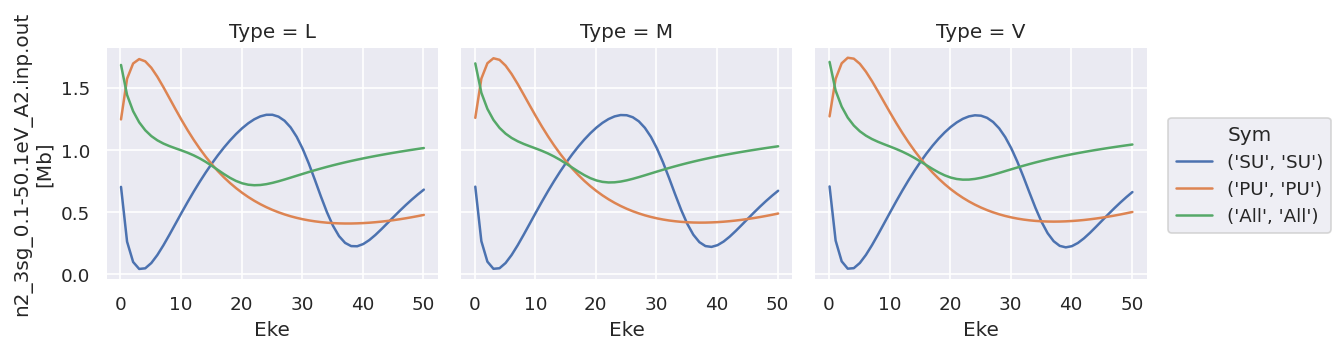

In [14]:
# Try plotting independently... this allows for independent y-axis scaling over data types.
daPlot.sel({'XC':'SIGMA'}).plot.line(x='Eke', col='Type');
daPlot.sel({'XC':'BETA'}).plot.line(x='Eke', col='Type');
# OK

## ep.lmPlot

Designed for multi-dim plotting of matrix elements or $\beta$ parameters, see [plotting routines page for details](https://epsproc.readthedocs.io/en/dev/demos/ePSproc_demo_matE_plotting_Feb2020.html#Plotting-maps-with-lmPlot).



## Holoviews

Requires conversion from Xarray data-array or dataset, but [then pretty flexible](http://holoviews.org/user_guide/Gridded_Datasets.html).

Basics here from [HV Gridded Datasets intro page, plus embelishments](http://holoviews.org/user_guide/Gridded_Datasets.html).

NOTE: this is probably easier with a simpler datatype, e.g. beta parameters, rather than full set of matrix elements.

### With Matplotlib backend

In [9]:
# Init - without this no plots will be displayed
hv.extension('matplotlib')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [32]:
# hv_ds = hv.Dataset(dataSet[0].sel({'Type':'L', 'it':1, 'Cont':'SU'}).squeeze().unstack('LM').sel({'m':0,'mu':0}).real)  # OK
# hv_ds = hv.Dataset(dataSet[0].sel({'Type':'L', 'it':1, 'Cont':'SU'}).squeeze().unstack('LM').real)  # OK
hv_ds = hv.Dataset(dataSet[0].sel({'Type':'L', 'it':1}).unstack(['LM','Sym']).sum(['Targ','Total']).real) # OK - reduce Sym dims.
print(hv_ds)

:Dataset   [mu,Eke,l,m,Cont]   (n2_3sg_0.1-50.1eV_A2.inp.out)


Basic plotting will generate plots of specified type, with specified key dimensions, plus sliders or lists for other dims.

:HoloMap   [mu,m,Cont]
   :Image   [Eke,l]   (n2_3sg_0.1-50.1eV_A2.inp.out)
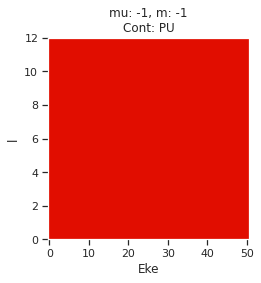
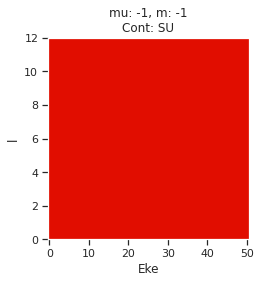
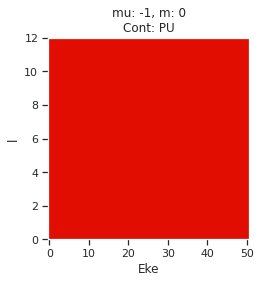
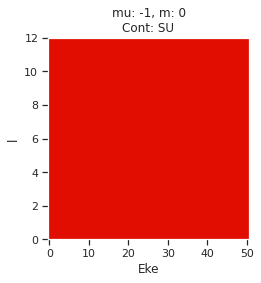
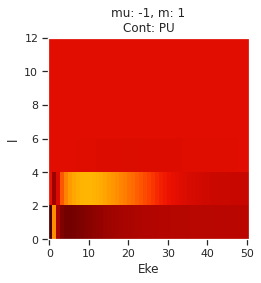
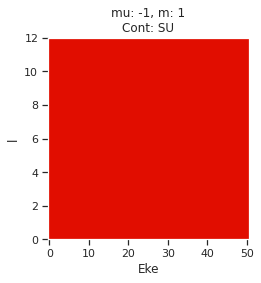
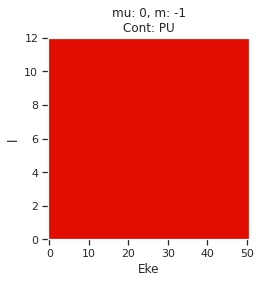
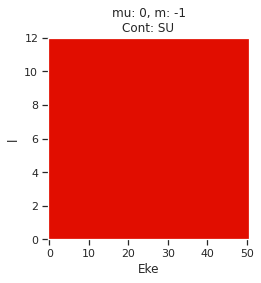
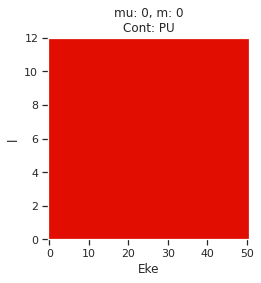
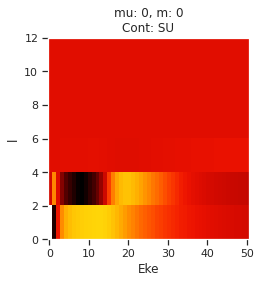
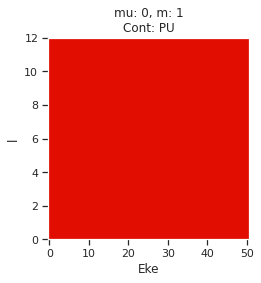
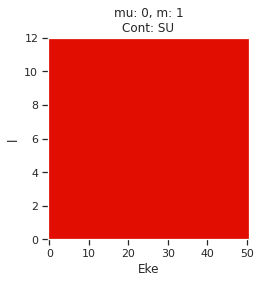
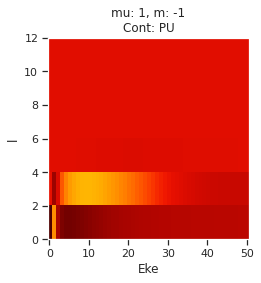
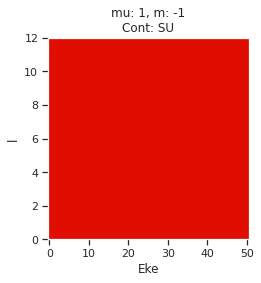
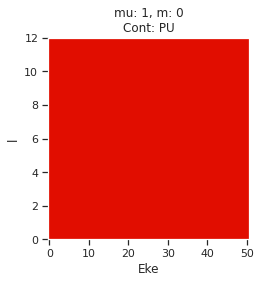
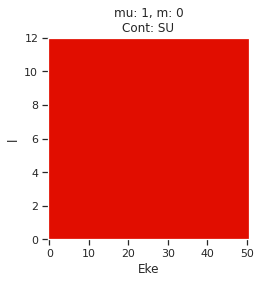
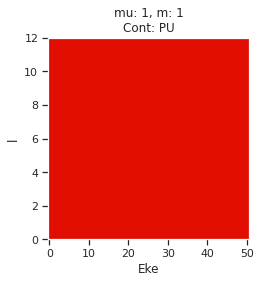
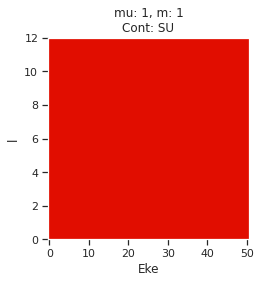

In [42]:
matEplot = hv_ds.to(hv.Image, kdims=["Eke", "l"])
matEplot.opts(aspect=1)

In [ ]:
matEplot = hv_ds.to(hv.Histogram, kdims=["Eke"])
matEplot

In [ ]:
# Was working to grid value... now broken???
(hv_ds.to(hv.Image, ['Eke', 'l'], 'm', ['mu']) +
hv.HoloMap({x: hv.Scatter3D(dataset3d.select(x=mu)) for x in range(3)}, kdims='mu'))

In [ ]:
.to(hv.Distribution, 'Value', [], groupby='x').overlay()

### With bokeh backend

Provides interactivity in Notebook + HTML output.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
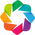

In [51]:
hv.extension('bokeh')

In [53]:
hv_ds = hv.Dataset(dataSet[0].sel({'Type':'L', 'it':1}).unstack(['LM','Sym']).sum(['Targ','Total']).real) # OK - reduce Sym dims.
print(hv_ds)

:Dataset   [mu,Eke,l,m,Cont]   (n2_3sg_0.1-50.1eV_A2.inp.out)


In [54]:
matEplot = hv_ds.to(hv.Image, kdims=["Eke", "l"], dynamic=False)
matEplot
matEplot.opts(frame_width=500, frame_height=500, colorbar=True, axiswise=True)  # Set additional options

:HoloMap   [mu,m,Cont]
   :Image   [Eke,l]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [55]:
# Facet with select + layout
matEplot.opts(frame_width=200, frame_height=200, colorbar=True, axiswise=True)  # Set additional options
# matEplot.select(mu={-1,0,1}).layout()
matEplot.select(Cont={'SU','PU'}).layout().cols(3)

:NdLayout   [mu,m,Cont]
   :Image   [Eke,l]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [56]:
# Facet by looping
# See http://holoviews.org/user_guide/Composing_Elements.html
img_list   = [hv_ds.select(Cont={x}).to(hv.Image, kdims=["Eke", "l"]) for x in ['SU', 'PU']]

layout = hv.Layout(img_list).cols(2)
layout

:Layout
   .HoloMap.I  :HoloMap   [mu,m,Cont]
      :Image   [Eke,l]   (n2_3sg_0.1-50.1eV_A2.inp.out)
   .HoloMap.II :HoloMap   [mu,m,Cont]
      :Image   [Eke,l]   (n2_3sg_0.1-50.1eV_A2.inp.out)

### Cross-sections

In [57]:
# hv_ds = hv.Dataset(dataXS[0].sel({'Type':'L'})) # Throws errors at plotting stage - stacked dim issue?
# hv_ds = hv.Dataset(dataXS[0].sel({'Type':'L'}).unstack()) # OK - Sym unstacked, but has some redundancy
hv_ds = hv.Dataset(dataXS[0].sel({'Type':'L'}).unstack().sum('Total')) # OK - reduce Sym dims.
print(hv_ds)

:Dataset   [XC,Eke,Cont]   (n2_3sg_0.1-50.1eV_A2.inp.out)


In [58]:
XSplot = hv_ds.to(hv.Curve, kdims=["Eke"], dynamic=False)
XSplot.opts(frame_width=500, frame_height=200, tools=['hover'])  # Set additional options

:HoloMap   [XC,Cont]
   :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [59]:
# Facet with select
XSplot.select(XC='BETA',Cont={'SU','PU','All'}).layout().cols(1)

:NdLayout   [XC,Cont]
   :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [60]:
XSplot = hv_ds.to(hv.Curve, kdims=["Eke"], dynamic=False)
# XSplot.select(XC='BETA',Cont={'SU','PU','All'}).layout().cols(1)
XSplot

:HoloMap   [XC,Cont]
   :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [61]:
curve_list   = [hv_ds.select(XC={x}).to(hv.Curve, kdims=["Eke"]) for x in ['SIGMA', 'BETA']]
layout = hv.Layout(curve_list)
layout

:Layout
   .HoloMap.I  :HoloMap   [XC,Cont]
      :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)
   .HoloMap.II :HoloMap   [XC,Cont]
      :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [62]:

# curve_list   = [hv_ds.select(XC={x},Cont={y}).to(hv.Curve, kdims=["Eke"]) for x in ['SIGMA', 'BETA'] for y in ['SU','PU']]
overlay = hv.Overlay(curve_list)
overlay

:Overlay
   .HoloMap.I  :HoloMap   [XC,Cont]
      :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)
   .HoloMap.II :HoloMap   [XC,Cont]
      :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [63]:
TRY THIS NEXT: http://holoviews.org/user_guide/Dimensioned_Containers.html

SyntaxError: invalid syntax (<ipython-input-63-89bc1f5589c7>, line 1)

In [ ]:
%%opts Curve {+axiswise}
# Overlay + layouts by dim
# Works well, except for shared axis limits.

# from holoviews import opts


hv_ds = hv.Dataset(dataXS[0].sel({'Type':'L'}).unstack().sum('Total')) # OK - reduce Sym dims.
print(hv_ds)

XSplot = hv_ds.to(hv.Curve, kdims=["Eke"], dynamic=False).opts(frame_width=500, tools=['hover'])
XSplotLayout = XSplot.overlay('Cont')  # Overlay symmetries
# XSplotLayout = XSplot.overlay('Cont').layout('XC').cols(1)  # Overlay symmetries
# XSplot.select(XC='BETA',Cont={'SU','PU','All'}).layout().cols(1)   # Select on symmetries

# XSplot.opts(width=500)  # Set additional options
# XSplot
XSplotLayout

In [ ]:
%%opts Curve {+axiswise}
# This should allow unlinked y-axis... but not working here? Issue with data structure?
# Same for adding to opts as per below, either directly or at plotting stage, or via options structure.
# See:
#   https://github.com/holoviz/holoviews/issues/2910
#   https://github.com/holoviz/holoviews/issues/2343
#   http://holoviews.org/FAQ.html

# Alternative - try setting options directly
cOpts = opts.Curve(axiswise=True)
lOpts = opts.Layout(framewise=True, shared_axes=False)

hv_ds = hv.Dataset(dataXS[0].sel({'Type':'L'}).unstack().sum('Total')) # OK - reduce Sym dims.
print(hv_ds)

XSplot = hv_ds.to(hv.Curve, kdims=["Eke"], dynamic=False).opts(frame_width=500, tools=['hover'], 
                                                               axiswise=True,).opts(cOpts)   # Nope
#                                                                opts.Curve(axiswise=True))  # Nope
XSplotLayout = XSplot.overlay('Cont').layout('XC').cols(1)  # Overlay symmetries
# XSplot.select(XC='BETA',Cont={'SU','PU','All'}).layout().cols(1)   # Select on symmetries

# XSplot.opts(width=500)  # Set additional options
# XSplot.opts(lOpts, cOpts)
XSplotLayout.opts(lOpts)  # .redim(XC='cross-section')  # Test redim - issue is really underlying datastructure...?

In [64]:
hv_ds = hv.Dataset(dataXS[0].sel({'Type':'L'}).unstack().sum('Total')) # OK - reduce Sym dims.
print(hv_ds)

XSplot = hv_ds.to(hv.Curve, kdims=["Eke"], dynamic=False).opts(frame_width=500, tools=['hover'])
XSplotLayout = XSplot.overlay('Cont').grid('XC')  # Overlay symmetries
# XSplot.select(XC='BETA',Cont={'SU','PU','All'}).layout().cols(1)   # Select on symmetries

# XSplot.opts(width=500)  # Set additional options
# XSplot
XSplotLayout

:Dataset   [XC,Eke,Cont]   (n2_3sg_0.1-50.1eV_A2.inp.out)


:GridSpace   [XC]
   :NdOverlay   [Cont]
      :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [65]:
# NEXT: link/unlink plots
# https://www.holoviews.org/user_guide/Linking_Plots.html

# Annotating data
# http://holoviews.org/user_guide/Annotating_Data.html

## Data reformat & datasets

Main issue with plotting as above is different datatypes (ranges), and also ways to extend to multiple datasets.

Try Xarray datasets for this capability - previously OK with XeF2 data tests, but currently missing updated file (on AntonJr)... [initial noodlings here](https://phockett.github.io/ePSdata/XeF2-preliminary/XeF2_multi-orb_comparisons_270320-dist.html).

In [66]:
# Basic try - stack to dataset with XC dim removed.
# This should be correct for keeping datatypes consistent.
# Can add an additional dim for multiple orbitals, theory vs. expt, etc.
ds = xr.Dataset({'beta':dataXS[0].sel({'XC':'BETA'}).drop('XC'), 'sigma':dataXS[0].sel({'XC':'SIGMA'}).drop('XC')})
ds

<xarray.Dataset>
Dimensions:  (Eke: 51, Sym: 3, Type: 3)
Coordinates:
    Ehv      (Eke) float64 15.68 16.68 17.68 18.68 ... 62.68 63.68 64.68 65.68
  * Type     (Type) object 'L' 'M' 'V'
  * Sym      (Sym) MultiIndex
  - Total    (Sym) object 'SU' 'PU' 'All'
  - Cont     (Sym) object 'SU' 'PU' 'All'
  * Eke      (Eke) float64 0.1 1.1 2.1 3.1 4.1 5.1 ... 46.1 47.1 48.1 49.1 50.1
Data variables:
    beta     (Sym, Eke, Type) float64 0.7019 0.7036 0.7053 ... 1.014 1.028 1.042
    sigma    (Sym, Eke, Type) float64 2.719 2.954 3.209 ... 1.013 0.9229 0.8423

In [67]:
hv_ds = hv.Dataset(ds.unstack().sum('Total')) # OK - reduce Sym dims.
print(hv_ds)

# Seem to have to subselect on vdims here to define which dataset to plot...?
#  See https://github.com/holoviz/holoviews/issues/2015
# With vdims set
XSplot = hv_ds.to(hv.Curve, kdims=["Eke"], vdims=['sigma'], dynamic=False).opts(frame_width=500, tools=['hover'])
# Try grouping... bsically sets everything to same plotting dim, so not much use here
# XSplot = hv_ds.to(hv.Curve, kdims=["Eke"], vdims=['Cont']).opts(frame_width=500, tools=['hover'])


XSplotLayout = XSplot.overlay('Cont') #.layout()  # Overlay symmetries
# XSplotLayout = XSplot.overlay('Cont').layout('XC').cols(1)  # Overlay symmetries
# XSplot.select(XC='BETA',Cont={'SU','PU','All'}).layout().cols(1)   # Select on symmetries

# XSplot.opts(width=500)  # Set additional options
# XSplot
XSplotLayout  # Only plots 'beta' data??? AH - set vdims

:Dataset   [Type,Eke,Cont]   (beta,sigma)


:HoloMap   [Type]
   :NdOverlay   [Cont]
      :Curve   [Eke]   (sigma)

In [68]:
# As above, but with layout too
# THIS IS A BIT OF EFFORT, but now gives plots as desired (linked x-axes, plus selectors)
# Same should work with dataarray and subselection?

dsLayout = hv_ds.to(hv.Curve, kdims=["Eke"], vdims=['sigma'], dynamic=False).overlay('Cont').opts(frame_width=500, tools=['hover'], show_grid=True, padding=0.01) +\
           hv_ds.to(hv.Curve, kdims=["Eke"], vdims=['beta'], dynamic=False).overlay('Cont').opts(frame_width=500, tools=['hover'])
# May want to add padding here, although not sure why it's necessary in this case!

dsLayout.cols(1)  # .opts(frame_width=500, tools=['hover']).overlay('Cont')

:Layout
   .HoloMap.I  :HoloMap   [Type]
      :NdOverlay   [Cont]
         :Curve   [Eke]   (sigma)
   .HoloMap.II :HoloMap   [Type]
      :NdOverlay   [Cont]
         :Curve   [Eke]   (beta)

In [69]:
# Try looping

# Set options, then pass below
# sharedOpts = opts.Curve(frame_width=500, tools=['hover'], show_grid=True, padding=0.01)
# As defaults - in this case don't pass below
# Additional: with labelled case for "groups" set below. Way to do this automagically in loop?
#  http://holoviews.org/user_guide/Applying_Customizations.html
sharedOpts = opts.defaults(opts.Curve(frame_width=500, tools=['hover'], show_grid=True, padding=0.01),
                           opts.Curve('L', line_dash='dashed'))

# Loop and set dict
# dsPlotSet = {}
# for vdim in ds.var():
#     dsPlotSet[vdim] = hv_ds.to(hv.Curve, kdims=["Eke"], vdims=vdim, dynamic=False).overlay('Cont').opts(sharedOpts)
    
# Not sure how to sum these to plot...?    
# hvDsPlot = sum(dsPlotSet.values(), [])
# from itertools import chain
# res = list(chain(*dsPlotSet.values())) 

# Loop and set object directly...
dsPlotSet = hv.Layout()
for vdim in ds.var():
    # With Type selection box
#     dsPlotSet += hv_ds.to(hv.Curve, kdims=["Eke"], vdims=vdim, dynamic=False).overlay(['Cont']).opts(sharedOpts)
   
    # With Type overlay
    # This is not bad, although ledgend and style a bit messy.
    # Should style lines by (Sym, Type) for clarity, not sure how just yet.
    dsPlotSet += hv_ds.to(hv.Curve, kdims=["Eke"], vdims=vdim, dynamic=True).overlay(['Cont','Type'])  #.opts(sharedOpts)
    
    # Loop over type to allow for different plotting options
    # Not working yet - not sure how to init empty object in this case
#     dsPlotSetT = hv.Curve()
#     dsPlotSetT = hv.Layout()
#     for dim in ds[vdim].Type:
#         dsPlotSetT *= hv_ds.to(hv.Curve, kdims=["Eke"], vdims=vdim, dynamic=True, group=dim).overlay(['Cont'])
    
#     dsPlotSet += dsPlotSetT
    
dsPlotSet.cols(1)

:Layout
   .NdOverlay.I  :NdOverlay   [Type,Cont]
      :Curve   [Eke]   (beta)
   .NdOverlay.II :NdOverlay   [Type,Cont]
      :Curve   [Eke]   (sigma)

In [70]:
print(dsPlotSet)

:Layout
   .NdOverlay.I  :NdOverlay   [Type,Cont]
      :Curve   [Eke]   (beta)
   .NdOverlay.II :NdOverlay   [Type,Cont]
      :Curve   [Eke]   (sigma)


In [71]:
# list(ds.var())
ds['beta'].Type

<xarray.DataArray 'Type' (Type: 3)>
array(['L', 'M', 'V'], dtype=object)
Coordinates:
  * Type     (Type) object 'L' 'M' 'V'

## Try hvplot

Provides interface to Holoviews, use as per Xarray native plotting.

https://hvplot.holoviz.org/

In [72]:
import hvplot.xarray 

In [73]:
# # Matrix elements... TOO COMPLICATED!!!
# # Plot with faceting on symmetry
# daPlot = ep.matEleSelector(dataSet[0], thres=1e-2, dims = 'Eke', sq = True).sum('mu').squeeze()
# # daPlot.pipe(np.abs).fillna(0).hvplot.line(x='Eke', col='Sym', row='Type');  # Issue with NaNs and/or multilevel index
# daPlot.pipe(np.abs).fillna(0).unstack().hvplot.line(x='Eke', col='Cont', row='Type')  # Returns object... and lots of errors!

In [74]:
# Try XS from dataarray - still throwing errors
# Usually "TypeError: method_wrapper() got an unexpected keyword argument 'per_element'"
# test = dataXS[0].sel({'Type':'L'}).unstack().sum('Total').hvplot.line(x='Eke', col='Cont')
# test

# Try simplifying...
# Working OK with reduced 1D data
# OK
# test = dataXS[0].sel({'Type':'L', 'XC':'SIGMA'}).unstack().sum('Total').sel({'Cont':'PU'}).hvplot.line(x='Eke')
# Nope
# test = dataXS[0].sel({'Type':'L', 'XC':'SIGMA'}).unstack().sum('Total').sel({'Cont':'PU'}).hvplot()
# Works, but junk
# test = dataXS[0].sel({'Type':'L', 'XC':'SIGMA'}).unstack().sum('Total').hvplot.line(x='Eke', y='Cont')
# Nope
# test = dataXS[0].sel({'Type':'L', 'XC':'SIGMA'}).unstack().sum('Total').hvplot.line(x='Eke', y=['SU','PU','All'])
# Nope
# test = dataXS[0].sel({'Type':'L', 'XC':'SIGMA'}).unstack().sum('Total').hvplot.line(x='Eke', groupby='Cont')

# AHHA - use 'by' for overlay dim.
# See https://hvplot.holoviz.org/user_guide/Gridded_Data.html
test = dataXS[0].sel({'Type':'L', 'XC':'SIGMA'}).unstack().sum('Total').hvplot.line(x='Eke', by='Cont')
test2 = dataXS[0].sel({'Type':'L', 'XC':'BETA'}).unstack().sum('Total').hvplot.line(x='Eke', by='Cont', line_dash='dashed' )


(test + test2).cols(1)  # Works, but have linked y-axis again, doh!
# test*test2  # Ugly - overlays everything and screws up legend

# Add a dim... now throws "TypeError: method_wrapper() got an unexpected keyword argument 'per_element'"
# Looks like issue with passing to HV selection widget?
# test = dataXS[0].sel({'XC':'SIGMA'}).unstack().sum('Total').hvplot.line(x='Eke', by='Cont')
# test

:Layout
   .NdOverlay.I  :NdOverlay   [Cont]
      :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)
   .NdOverlay.II :NdOverlay   [Cont]
      :Curve   [Eke]   (n2_3sg_0.1-50.1eV_A2.inp.out)

In [ ]:
# Test different selection method...
daPlot = ep.matEleSelector(dataXS[0], thres=1e-2, dims = 'Eke', sq = True).squeeze()
# daPlot.sel({'XC':'SIGMA'}).plot.line(x='Eke', col='Type');
daPlot.sel({'XC':'SIGMA'}).unstack().sum('Total').hvplot.line(x='Eke', by='Type')  # Ugh... multiindex issues.

In [ ]:
# Try XS from dataset
# Basic try - stack to dataset with XC dim removed.
ds = xr.Dataset({'beta':dataXS[0].sel({'XC':'BETA'}).drop('XC'), 'sigma':dataXS[0].sel({'XC':'SIGMA'}).drop('XC')})

# ds['sigma'].hvplot()  # NotImplementedError: isna is not defined for MultiIndex
# ds['sigma'].fillna(0).hvplot()  # Same error
ds['sigma'].unstack().sum('Total').hvplot.line(x='Eke', by='Cont', groupby='Type')  # TypeError: method_wrapper() got an unexpected keyword argument 'per_element'
# ds.hvplot()

In [77]:
# Try with looping...



## Scratch

In [ ]:
holomap = hv_ds.to(hv.HoloMap, kdims=["Eke"])
holomap  #.overlay('XC')

## Versions

In [79]:
%load_ext version_information
%version_information

Software versions
Python 3.7.6 64bit [GCC 7.3.0]
IPython 7.13.0
OS Linux 5.3.0 62 generic x86_64 with debian buster sid
Fri Jul 03 12:15:30 2020 EDT

In [84]:
import scooby
scooby.Report(additional=['holoviews', 'hvplot', 'xarray', 'matplotlib', 'bokeh'])

--------------------------------------------------------------------------------
  Date: Fri Jul 03 12:18:34 2020 EDT

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

         holoviews : 1.12.6
            hvplot : 0.6.0
            xarray : 0.13.0
        matplotlib : 3.2.0
             bokeh : 1.4.0
             numpy : 1.18.1
             scipy : 1.3.1
           IPython : 7.13.0
            scooby : 0.5.5

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------